# Projet_8 : cityscapes dataset

This notebook will contain all exploration regarding the EDA of cityscape dataset, the choice of a model to segment images, and the pipeline to do it

The CityScape dataset contains pre-treated images, so we won't be able to work with the origin images 
We will probably have to augment data 


In [419]:
#librairies
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil
from collections import Counter
from collections import namedtuple

from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from segmentation_models import get_preprocessing
import torch
from torch import nn

# image imports
from matplotlib.image import imread
import PIL
from PIL import Image, ImageFilter, ImageEnhance

from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from keras.metrics import IoU
from tensorflow.keras.metrics import MeanIoU

import albumentations as A
import cv2

In [352]:
"""#first we need to load the "training" image set, which will be our working set

# path to train repertory
mask_path = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"
# Choose a city from which to pull images
city = "aachen"  
mask_files = sorted(os.listdir(os.path.join(mask_path, city)))[:4] #select only the 4 first files

# Display mask
fig, axes = plt.subplots(len(mask_files), 1, figsize=(10, 5 * len(mask_files)))

for i, mask_file in enumerate(mask_files):
    if mask_file.endswith(".png"):  # choose what to display with options : _color, _instanceIds, _labelIds
        mask = cv2.imread(os.path.join(mask_path, city, mask_file), cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(mask, cmap="jet", alpha=0.7)
        axes[i].set_title(mask_file)
        axes[i].axis("off")
    else:
        axes[i].set_title(mask_file) #can't display json files

plt.tight_layout()
plt.show()"""

'#first we need to load the "training" image set, which will be our working set\n\n# path to train repertory\nmask_path = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"\n# Choose a city from which to pull images\ncity = "aachen"  \nmask_files = sorted(os.listdir(os.path.join(mask_path, city)))[:4] #select only the 4 first files\n\n# Display mask\nfig, axes = plt.subplots(len(mask_files), 1, figsize=(10, 5 * len(mask_files)))\n\nfor i, mask_file in enumerate(mask_files):\n    if mask_file.endswith(".png"):  # choose what to display with options : _color, _instanceIds, _labelIds\n        mask = cv2.imread(os.path.join(mask_path, city, mask_file), cv2.IMREAD_GRAYSCALE)\n        axes[i].imshow(mask, cmap="jet", alpha=0.7)\n        axes[i].set_title(mask_file)\n        axes[i].axis("off")\n    else:\n        axes[i].set_title(mask_file) #can\'t display json files\n\nplt.tight_layout()\nplt.show()'

In [353]:
"""#counting classes

class_counts = Counter()

for mask_file in mask_files:
    if mask_file.endswith("_labelIds.png"):
        mask = cv2.imread(os.path.join(mask_path, city, mask_file), cv2.IMREAD_GRAYSCALE)
        class_counts.update(mask.flatten())

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes CityScapes (label IDs)")
plt.ylabel("Nombre de pixels")
plt.title("Distribution des classes dans CityScapes")
plt.show()
"""

'#counting classes\n\nclass_counts = Counter()\n\nfor mask_file in mask_files:\n    if mask_file.endswith("_labelIds.png"):\n        mask = cv2.imread(os.path.join(mask_path, city, mask_file), cv2.IMREAD_GRAYSCALE)\n        class_counts.update(mask.flatten())\n\nplt.bar(class_counts.keys(), class_counts.values())\nplt.xlabel("Classes CityScapes (label IDs)")\nplt.ylabel("Nombre de pixels")\nplt.title("Distribution des classes dans CityScapes")\nplt.show()\n'

In [354]:
"""mask_shapes = [cv2.imread(os.path.join(mask_path, city, mask), cv2.IMREAD_GRAYSCALE).shape for mask in mask_files if mask.endswith("_labelIds.png")]

print("Dimensions des masques :", mask_shapes)
"""

'mask_shapes = [cv2.imread(os.path.join(mask_path, city, mask), cv2.IMREAD_GRAYSCALE).shape for mask in mask_files if mask.endswith("_labelIds.png")]\n\nprint("Dimensions des masques :", mask_shapes)\n'

In [355]:
"""#understanding Counter()
#Counter() works as a dictonnary, storing elements as keys and their population as values
class_counts.keys()"""

'#understanding Counter()\n#Counter() works as a dictonnary, storing elements as keys and their population as values\nclass_counts.keys()'

## Generalize the 32 categories into 8

We will generalize to ease the investigation

With a solution from github https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

This was taken care of in data_organization notebook

In [357]:
"""from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )
"""

"from collections import namedtuple\n\n\n#--------------------------------------------------------------------------------\n# Definitions\n#--------------------------------------------------------------------------------\n\n# a label and all meta information\nLabel = namedtuple( 'Label' , [\n\n    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .\n                    # We use them to uniquely name a class\n\n    'id'          , # An integer ID that is associated with this label.\n                    # The IDs are used to represent the label in ground truth images\n                    # An ID of -1 means that this label does not have an ID and thus\n                    # is ignored when creating ground truth images (e.g. license plate).\n                    # Do not modify these IDs, since exactly these IDs are expected by the\n                    # evaluation server.\n\n    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then creat

In [358]:
"""
#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
"""

"\n#--------------------------------------------------------------------------------\n# A list of all labels\n#--------------------------------------------------------------------------------\n\n# Please adapt the train IDs as appropriate for your approach.\n# Note that you might want to ignore labels with ID 255 during training.\n# Further note that the current train IDs are only a suggestion. You can use whatever you like.\n# Make sure to provide your results using the original IDs and not the training IDs.\n# Note that many IDs are ignored in evaluation and thus you never need to predict these!\n\nlabels = [\n    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color\n    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),\n    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

In [359]:
"""for label in labels:
    print(label.id, "is", label.name,"and is in category", label.categoryId)"""

'for label in labels:\n    print(label.id, "is", label.name,"and is in category", label.categoryId)'

In [360]:
"""#display classes distribution

MAIN_PATH = os.path.join(mask_path, city)

class_counts = Counter()

for mask_file in mask_files:
    FILE_PATH = os.path.join(MAIN_PATH, os.path.basename(mask_file))
    #print(FILE_PATH)
    if FILE_PATH.endswith("_labelIds.png"):
        mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
        class_counts.update(mask.flatten())
        
        plt.bar(class_counts.keys(), class_counts.values())
        plt.xlabel("Classes CityScapes (label IDs)")
        plt.ylabel("Nombre de pixels")
        plt.title("Distribution des classes dans CityScapes")
        plt.show()"""

'#display classes distribution\n\nMAIN_PATH = os.path.join(mask_path, city)\n\nclass_counts = Counter()\n\nfor mask_file in mask_files:\n    FILE_PATH = os.path.join(MAIN_PATH, os.path.basename(mask_file))\n    #print(FILE_PATH)\n    if FILE_PATH.endswith("_labelIds.png"):\n        mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)\n        class_counts.update(mask.flatten())\n        \n        plt.bar(class_counts.keys(), class_counts.values())\n        plt.xlabel("Classes CityScapes (label IDs)")\n        plt.ylabel("Nombre de pixels")\n        plt.title("Distribution des classes dans CityScapes")\n        plt.show()'

In [361]:
"""#we'll copy a few files from each cities from the train directory

#file_to_copy = x.endswith("_labelIds.png")
main_path = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"
list_of_cities = os.listdir(main_path)
for city in list_of_cities:
    files = sorted(os.listdir(os.path.join(main_path, city)))
    # print(len(files)) # how populated is the folder 
    label_files = []
    for file in files:
        if file.endswith("_labelIds.png"):
            # print(file)
            label_files.append(file)

#label_files
"""

'#we\'ll copy a few files from each cities from the train directory\n\n#file_to_copy = x.endswith("_labelIds.png")\nmain_path = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"\nlist_of_cities = os.listdir(main_path)\nfor city in list_of_cities:\n    files = sorted(os.listdir(os.path.join(main_path, city)))\n    # print(len(files)) # how populated is the folder \n    label_files = []\n    for file in files:\n        if file.endswith("_labelIds.png"):\n            # print(file)\n            label_files.append(file)\n\n#label_files\n'

In [362]:
"""# take 10% of each folder 
total = len(label_files)
percent = np.round((total)/10).astype(np.int64)
int_percent = percent
x = np.random.randint(0, total+1, percent)
x

for each in x:
    print(label_files[each-1])
    #label_files[x]
    #print(os.path.join(main_path, city))"""

'# take 10% of each folder \ntotal = len(label_files)\npercent = np.round((total)/10).astype(np.int64)\nint_percent = percent\nx = np.random.randint(0, total+1, percent)\nx\n\nfor each in x:\n    print(label_files[each-1])\n    #label_files[x]\n    #print(os.path.join(main_path, city))'

In [363]:
"""path_to_train_file = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"
train_copies_folder = "data/train_copies/"

list_of_cities = os.listdir(path_to_train_file)

files_to_copy = []

#select 10% of _labelIds files randomly for each cities
for city in list_of_cities:
    files = sorted(os.listdir(os.path.join(path_to_train_file, city)))
    label_files = []
    
    for file in files:
        if file.endswith("_labelIds.png"):
            label_files.append(file)
    total = len(label_files)
    percent = np.round((total)/10).astype(np.int64)
    random_selection = np.random.choice(total, percent, replace=False)
                
    for each in random_selection:
        path = os.path.join(city,label_files[each])
        files_to_copy.append(path)

#copy everything (v2)
if not os.path.exists(train_copies_folder):
    os.makedirs(train_copies_folder)
    for mask_file in files_to_copy:
        FILE_PATH = os.path.join(path_to_train_file, mask_file)
        FILE = os.path.basename(mask_file)
        COPIES_PATH = os.path.join(train_copies_folder, FILE)
        shutil.copy(FILE_PATH, COPIES_PATH)
        #print("Successfully copied :", mask_file)
    print("Successfully copied :", len(files_to_copy), "files")
else:
    print("folder already exists, nothing will be copied")"""

'path_to_train_file = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"\ntrain_copies_folder = "data/train_copies/"\n\nlist_of_cities = os.listdir(path_to_train_file)\n\nfiles_to_copy = []\n\n#select 10% of _labelIds files randomly for each cities\nfor city in list_of_cities:\n    files = sorted(os.listdir(os.path.join(path_to_train_file, city)))\n    label_files = []\n    \n    for file in files:\n        if file.endswith("_labelIds.png"):\n            label_files.append(file)\n    total = len(label_files)\n    percent = np.round((total)/10).astype(np.int64)\n    random_selection = np.random.choice(total, percent, replace=False)\n                \n    for each in random_selection:\n        path = os.path.join(city,label_files[each])\n        files_to_copy.append(path)\n\n#copy everything (v2)\nif not os.path.exists(train_copies_folder):\n    os.makedirs(train_copies_folder)\n    for mask_file in files_to_copy:\n        FILE_PATH = os.path.join(path_to_train_file, mask_file)\n     

In [364]:
"""mask_folder = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"
img_folder = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train"
copies_folder = "data/copies_all"

list_of_cities = os.listdir(mask_folder)

selected_files = []

#select 10% of _labelIds files randomly for each cities
for city in list_of_cities:
    mask_files = sorted(os.listdir(os.path.join(mask_folder, city)))
    img_files = sorted(os.listdir(os.path.join(img_folder, city)))
    label_files = []

    for file in mask_files:
        if file.endswith("_labelIds.png"):
            label_files.append(file)
            
    total = len(label_files)
    percent = np.round((total)/10).astype(np.int64)
    random_selection = np.random.choice(total, percent, replace=False)
                
    for each in random_selection:
        img_path = os.path.join(city, img_files[each])
        label_path = os.path.join(city, label_files[each])
        selected_files.extend([label_path, img_path])

#selected_files

#display first images and their label
for file in selected_files[:2]:
        if file.endswith("_labelIds.png"):    
            file_path = os.path.join(mask_folder, file)
            # with PILLOW
        else:
            file_path = os.path.join(img_folder, file)
        img = Image.open(file_path) 
        
        #img.show() => open image navigator by default
        plt.imshow(img)
        plt.show()

"""

'mask_folder = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"\nimg_folder = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train"\ncopies_folder = "data/copies_all"\n\nlist_of_cities = os.listdir(mask_folder)\n\nselected_files = []\n\n#select 10% of _labelIds files randomly for each cities\nfor city in list_of_cities:\n    mask_files = sorted(os.listdir(os.path.join(mask_folder, city)))\n    img_files = sorted(os.listdir(os.path.join(img_folder, city)))\n    label_files = []\n\n    for file in mask_files:\n        if file.endswith("_labelIds.png"):\n            label_files.append(file)\n            \n    total = len(label_files)\n    percent = np.round((total)/10).astype(np.int64)\n    random_selection = np.random.choice(total, percent, replace=False)\n                \n    for each in random_selection:\n        img_path = os.path.join(city, img_files[each])\n        label_path = os.path.join(city, label_files[each])\n        selected_files.extend([label_path, img_path

In [365]:
"""#copy files (v3)
if os.path.exists(copies_folder):
    print("path already exists, nothing was copied")
else:
    os.makedirs(copies_folder)
    for file in selected_files:
        FILE = os.path.basename(file)
        if file.endswith("_labelIds.png"):
            MASK_FILE_PATH = os.path.join(mask_folder, file)
            COPIES_PATH = os.path.join(copies_folder, FILE)
            #img = Image.open(MASK_FILE_PATH)
            shutil.copy(MASK_FILE_PATH, COPIES_PATH)
        else:
            IMG_FILE_PATH = os.path.join(img_folder, file)
            COPIES_PATH = os.path.join(copies_folder, FILE)
            #img = Image.open(IMG_FILE_PATH)
            shutil.copy(IMG_FILE_PATH, COPIES_PATH)
        #img.show() => open image navigator by default
        #plt.imshow(img)
        #print(COPIES_PATH)
        #plt.show()
    print("Successfully copied :", len(selected_files), "files")
"""

'#copy files (v3)\nif os.path.exists(copies_folder):\n    print("path already exists, nothing was copied")\nelse:\n    os.makedirs(copies_folder)\n    for file in selected_files:\n        FILE = os.path.basename(file)\n        if file.endswith("_labelIds.png"):\n            MASK_FILE_PATH = os.path.join(mask_folder, file)\n            COPIES_PATH = os.path.join(copies_folder, FILE)\n            #img = Image.open(MASK_FILE_PATH)\n            shutil.copy(MASK_FILE_PATH, COPIES_PATH)\n        else:\n            IMG_FILE_PATH = os.path.join(img_folder, file)\n            COPIES_PATH = os.path.join(copies_folder, FILE)\n            #img = Image.open(IMG_FILE_PATH)\n            shutil.copy(IMG_FILE_PATH, COPIES_PATH)\n        #img.show() => open image navigator by default\n        #plt.imshow(img)\n        #print(COPIES_PATH)\n        #plt.show()\n    print("Successfully copied :", len(selected_files), "files")\n'

In [366]:
"""#et maintenant on copie image et labels ! je ne copie que les labelIds ??? je transforme les image en labelsIds ????
copies_folder = "data/copies_all"

#copy everything (v2)
if not os.path.exists(copies_folder):
    os.makedirs(copies_folder)
    for file in selected_files:
        FILE = os.path.basename(file)
        if file.endswith("_labelIds.png"):
            MASK_FILE_PATH = os.path.join(mask_folder, file)
            COPIES_PATH = os.path.join(copies_folder, FILE)
        else:
            IMG_FILE_PATH = os.path.join(img_folder, file)
            COPIES_PATH = os.path.join(copies_folder, FILE)
        #shutil.copy(IMG_FILE_PATH, COPIES_PATH)
        #shutil.copy(MASK_FILE_PATH, COPIES_PATH)
        #print("Successfully copied :", mask_file)
    print("Successfully copied :", len(selected_files), "files")
else:
    print("folder already exists, nothing will be copied")"""

'#et maintenant on copie image et labels ! je ne copie que les labelIds ??? je transforme les image en labelsIds ????\ncopies_folder = "data/copies_all"\n\n#copy everything (v2)\nif not os.path.exists(copies_folder):\n    os.makedirs(copies_folder)\n    for file in selected_files:\n        FILE = os.path.basename(file)\n        if file.endswith("_labelIds.png"):\n            MASK_FILE_PATH = os.path.join(mask_folder, file)\n            COPIES_PATH = os.path.join(copies_folder, FILE)\n        else:\n            IMG_FILE_PATH = os.path.join(img_folder, file)\n            COPIES_PATH = os.path.join(copies_folder, FILE)\n        #shutil.copy(IMG_FILE_PATH, COPIES_PATH)\n        #shutil.copy(MASK_FILE_PATH, COPIES_PATH)\n        #print("Successfully copied :", mask_file)\n    print("Successfully copied :", len(selected_files), "files")\nelse:\n    print("folder already exists, nothing will be copied")'

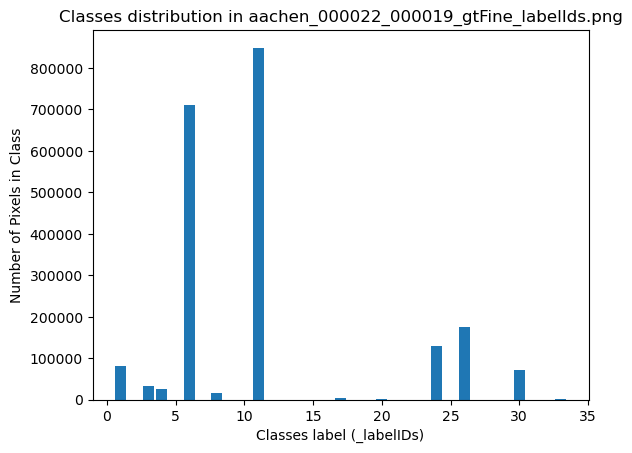

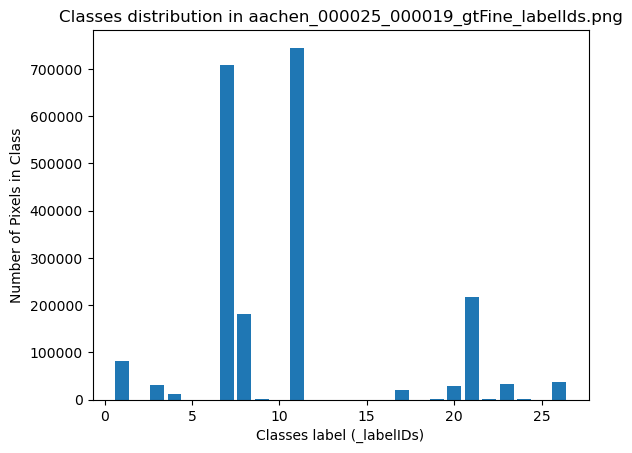

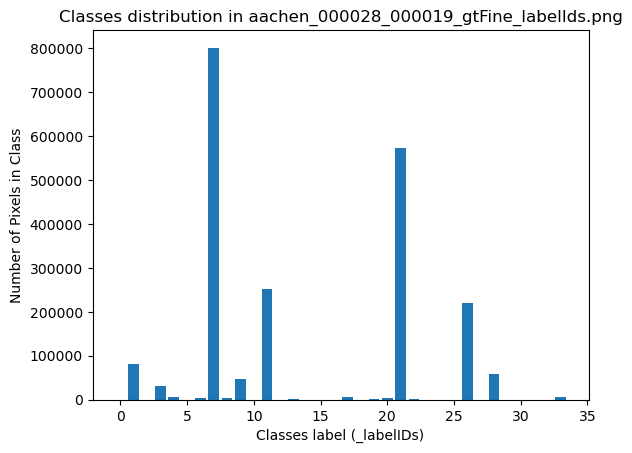

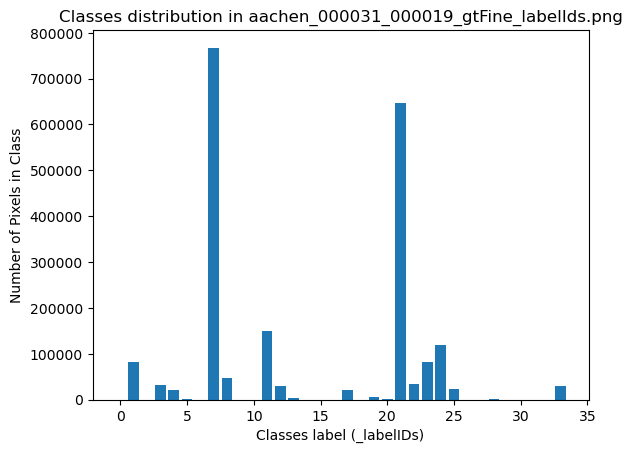

In [367]:
#display class distribution of a few files to ensure results
copies_folder = "data/train/masks"

copied_files = sorted(os.listdir(copies_folder))[:4]

#classes counter
for file in copied_files:
    if file.endswith("_labelIds.png"):
        FILE_PATH = os.path.join(copies_folder, file)
        #print(FILE_PATH)
    
        class_counts = Counter()
    
        mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
        class_counts.update(mask.flatten())
        
        plt.bar(class_counts.keys(), class_counts.values())
        plt.xlabel("Classes label (_labelIDs)")
        plt.ylabel("Number of Pixels in Class")
        plt.title(f"Classes distribution in {file}")
        plt.show()
    else:
        print("Raw image, won't display")
    


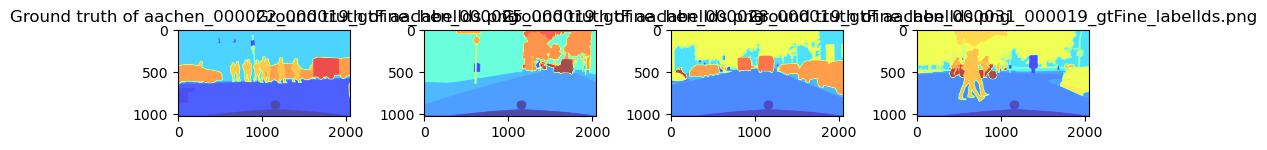

In [368]:
#display raw image and ground truth
fig, axes = plt.subplots(1, len(copied_files), figsize=(10, 20))

for i, file in enumerate(copied_files):
    FILE_PATH = os.path.join(copies_folder, os.path.basename(file))
    if file.endswith("_labelIds.png"):
        mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(mask, cmap="jet", alpha=0.7)
        axes[i].set_title(f"Ground truth of {file}")
    else:
        img = Image.open(FILE_PATH)
        axes[i].imshow(img)
        axes[i].set_title(file)
        
    
    #axes[i].axis("off")

plt.tight_layout()
plt.show() 

In [369]:
"""#Display mask
fig, axes = plt.subplots(len(copied_mask_files), 1, figsize=(10, 20))

for i, mask_file in enumerate(copied_mask_files):
    FILE_PATH = os.path.join(copies_folder, os.path.basename(mask_file))
    mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(mask, cmap="jet", alpha=0.7)
    axes[i].set_title(mask_file)
    axes[i].axis("off")

plt.tight_layout()
plt.show()"""

'#Display mask\nfig, axes = plt.subplots(len(copied_mask_files), 1, figsize=(10, 20))\n\nfor i, mask_file in enumerate(copied_mask_files):\n    FILE_PATH = os.path.join(copies_folder, os.path.basename(mask_file))\n    mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)\n    axes[i].imshow(mask, cmap="jet", alpha=0.7)\n    axes[i].set_title(mask_file)\n    axes[i].axis("off")\n\nplt.tight_layout()\nplt.show()'

In [370]:
"""#Generalize to 8 classes

#select only files to be converted
eligible_files = []
for file in os.listdir(copies_folder):
    if file.endswith("_labelIds.png"):
        eligible_files.append(file)
eligible_files

#create dictionnary
id_to_catId = {label.id: label.categoryId for label in labels}

#create generalized folder
output_path = "data/copies_generalized_classes"
if not os.path.exists(output_path):
    os.makedirs(output_path)

#checker if generalization is done
file_test = eligible_files[-1]
file_test_path = os.path.join(copies_folder, os.path.basename(file_test))
mask = cv2.imread(file_test_path, cv2.IMREAD_GRAYSCALE)
class_counts = Counter()
class_counts.update(mask.flatten())

if len(class_counts) == 8:
    print("generalization is already done")

else:
    print("need to generalize classes")
    
    transformer = np.vectorize(id_to_catId.get)
    
    for mask_file in eligible_files:
        mask_path = os.path.join(copies_folder, mask_file)
    
        # load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
        # apply new mask
        mask_transformed = transformer(mask)
    
        # save mask
        output_mask_path = os.path.join(output_path, mask_file)
        cv2.imwrite(output_mask_path, mask_transformed)

    print("generalization done")

#took 120 secs"""

'#Generalize to 8 classes\n\n#select only files to be converted\neligible_files = []\nfor file in os.listdir(copies_folder):\n    if file.endswith("_labelIds.png"):\n        eligible_files.append(file)\neligible_files\n\n#create dictionnary\nid_to_catId = {label.id: label.categoryId for label in labels}\n\n#create generalized folder\noutput_path = "data/copies_generalized_classes"\nif not os.path.exists(output_path):\n    os.makedirs(output_path)\n\n#checker if generalization is done\nfile_test = eligible_files[-1]\nfile_test_path = os.path.join(copies_folder, os.path.basename(file_test))\nmask = cv2.imread(file_test_path, cv2.IMREAD_GRAYSCALE)\nclass_counts = Counter()\nclass_counts.update(mask.flatten())\n\nif len(class_counts) == 8:\n    print("generalization is already done")\n\nelse:\n    print("need to generalize classes")\n    \n    transformer = np.vectorize(id_to_catId.get)\n    \n    for mask_file in eligible_files:\n        mask_path = os.path.join(copies_folder, mask_file)\

In [371]:
"""result = []
for file in os.listdir(copies_folder):
    if file.endswith("_leftImg8bit.png"):
        result.append(file)

len(result)"""

'result = []\nfor file in os.listdir(copies_folder):\n    if file.endswith("_leftImg8bit.png"):\n        result.append(file)\n\nlen(result)'

In [372]:
"""#create folder to save images related to masks
img_path = "data/copies_img_only"
if not os.path.exists(img_path):
    os.makedirs(img_path)
else:
    print("directory already exists")

for file in os.listdir(copies_folder):
    if file.endswith("_leftImg8bit.png"):
        copy_path = os.path.join(img_path, os.path.basename(file))
        origin_path = os.path.join(copies_folder, os.path.basename(file))
        #print(origin_path, "COPIED TO",copy_path)
        shutil.copy(origin_path, copy_path)

print("copied", len(os.listdir(img_path)) , "files")"""

'#create folder to save images related to masks\nimg_path = "data/copies_img_only"\nif not os.path.exists(img_path):\n    os.makedirs(img_path)\nelse:\n    print("directory already exists")\n\nfor file in os.listdir(copies_folder):\n    if file.endswith("_leftImg8bit.png"):\n        copy_path = os.path.join(img_path, os.path.basename(file))\n        origin_path = os.path.join(copies_folder, os.path.basename(file))\n        #print(origin_path, "COPIED TO",copy_path)\n        shutil.copy(origin_path, copy_path)\n\nprint("copied", len(os.listdir(img_path)) , "files")'

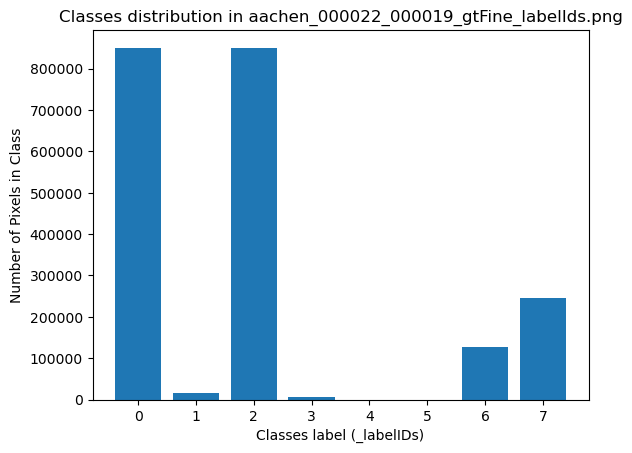

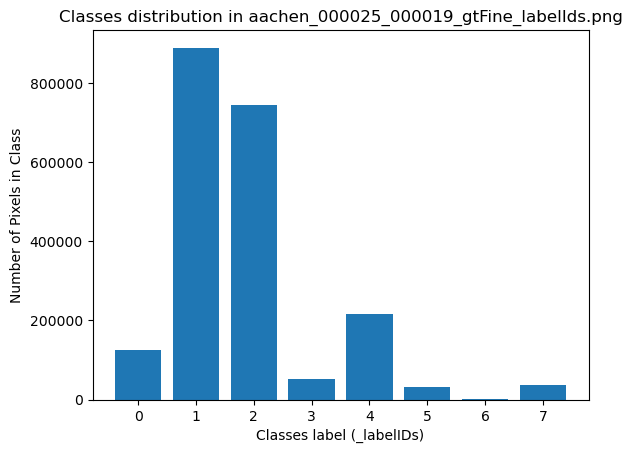

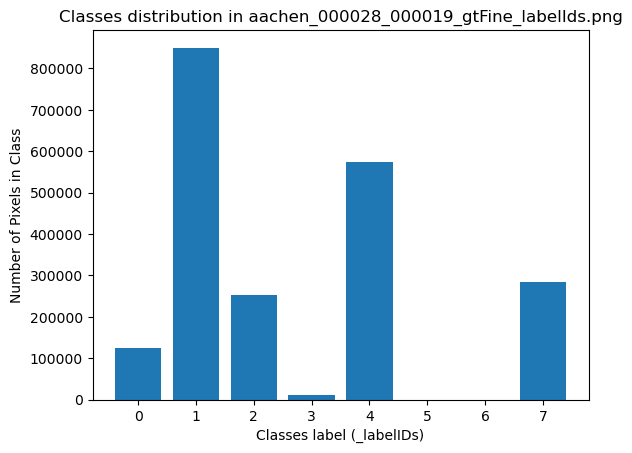

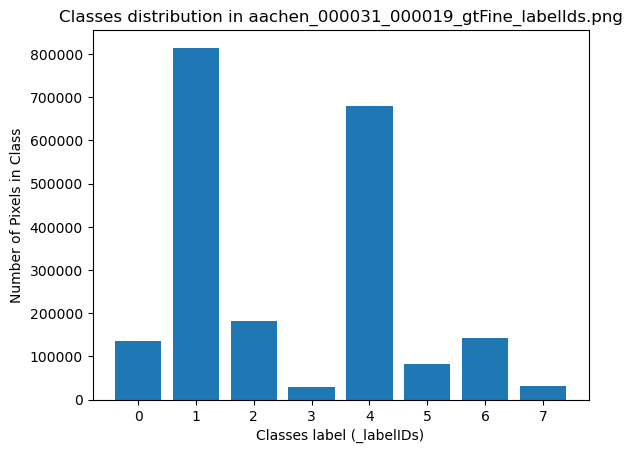

In [373]:
#checking the 4 first elements
output_path = "data/train/gen_masks"
generalized_mask_files = os.listdir(output_path)[:4]

#Generalized classes counter
for mask_file in generalized_mask_files:
    FILE_PATH = os.path.join(output_path, os.path.basename(mask_file))
    #print(FILE_PATH)

    class_counts = Counter()

    mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
    class_counts.update(mask.flatten())
    
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("Classes label (_labelIDs)")
    plt.ylabel("Number of Pixels in Class")
    plt.title(f"Classes distribution in {mask_file}")
    plt.show()

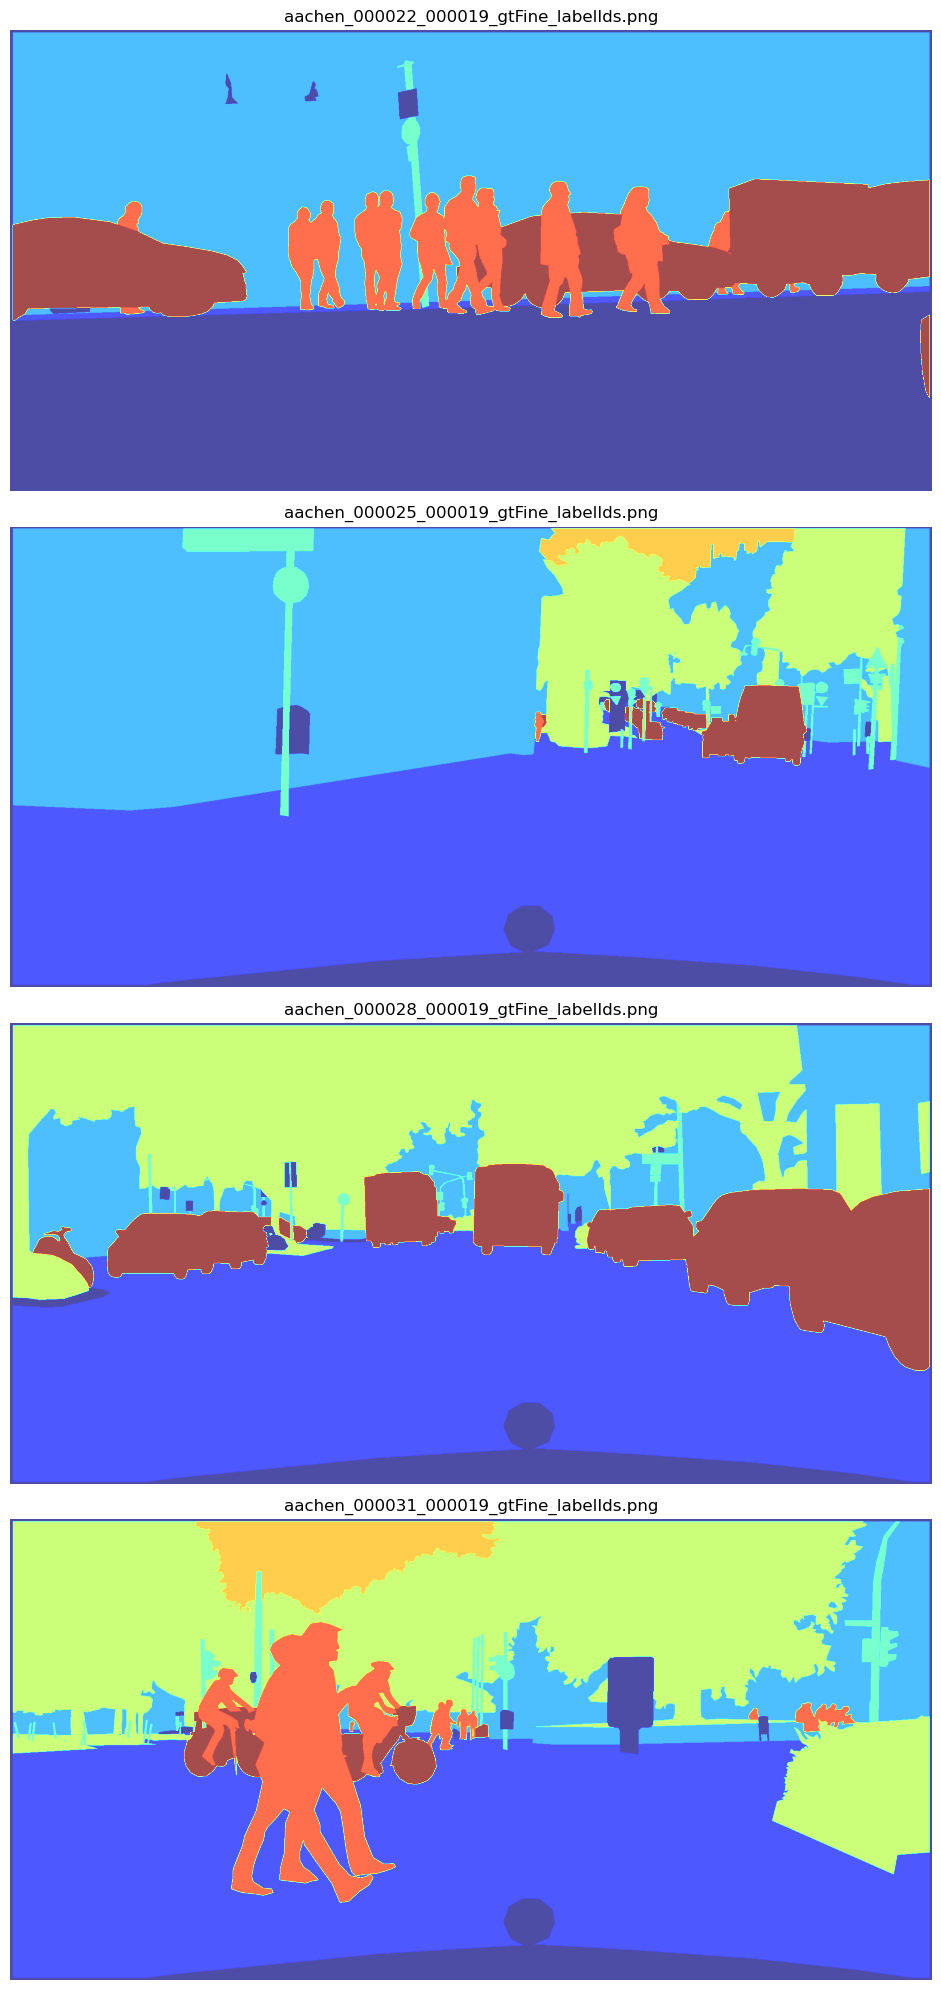

In [374]:
#Display mask
fig, axes = plt.subplots(len(generalized_mask_files), 1, figsize=(10, 20))

for i, mask_file in enumerate(generalized_mask_files):
    FILE_PATH = os.path.join(output_path, os.path.basename(mask_file))
    mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(mask, cmap="jet", alpha=0.7)
    axes[i].set_title(mask_file)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## EDA

Now that we have generalized our data into 8 classes, we can start investigating

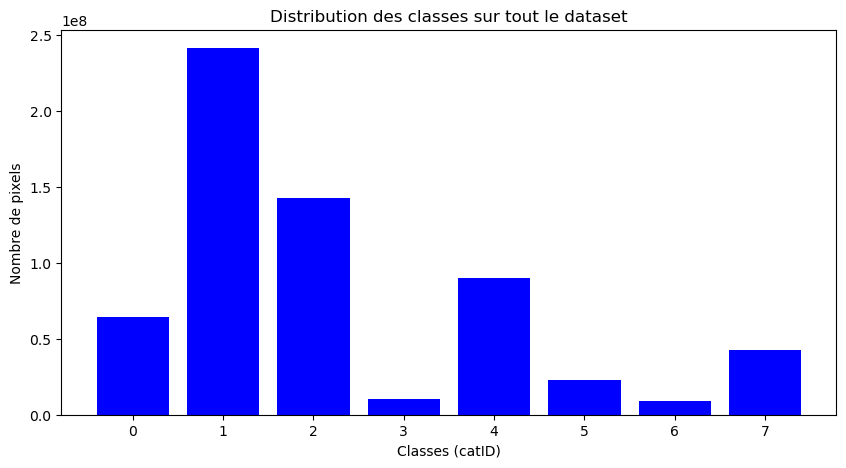

In [376]:
#What class distribution along the dataset pixel-wise ?

# Définition du chemin des masques transformés
generalized_mask_folder = "data/train/gen_masks"

# Initialiser un compteur pour toutes les classes
class_counts = Counter()

# Parcourir toutes les images du dataset
for mask_file in os.listdir(generalized_mask_folder):
    mask_path = os.path.join(generalized_mask_folder, mask_file)

    # Charger le masque en niveaux de gris
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Mettre à jour les comptes des classes
    class_counts.update(mask.flatten())

# Trier les classes par ID pour l'affichage
sorted_class_counts = dict(sorted(class_counts.items()))

# Afficher la distribution sous forme de graphe
plt.figure(figsize=(10, 5))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), color="blue")
plt.xlabel("Classes (catID)")
plt.ylabel("Nombre de pixels")
plt.title("Distribution des classes sur tout le dataset")
plt.xticks(list(sorted_class_counts.keys()))  # Afficher les labels correctement
plt.show()


Classes 3 and 6, "objects" and "human", seems to be the less represented classes. 

This means our problem is an imbalanced one.

We asserted that the classes are rare in pixels. We will now check if they are contained in each images, even if scarcely

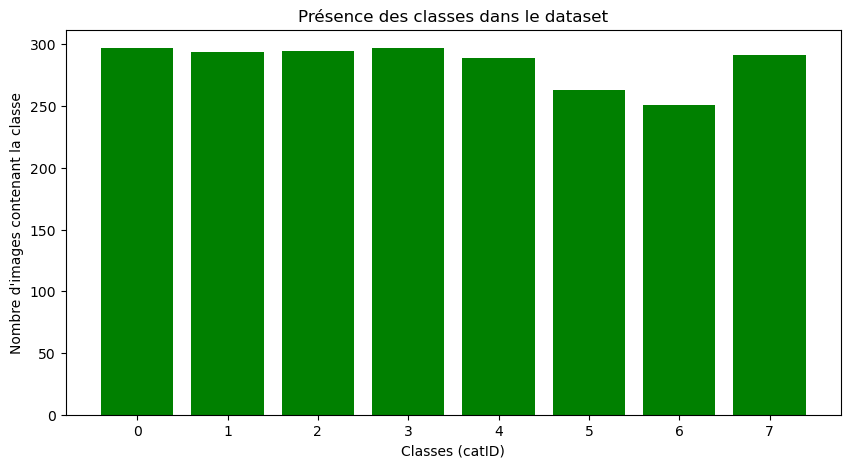

In [378]:
#are there any 'rare classes' in images ? 

# Initialiser un compteur du nombre d'images où chaque classe apparaît
class_presence = Counter()

# Parcourir toutes les images
for mask_file in os.listdir(generalized_mask_folder):
    mask_path = os.path.join(generalized_mask_folder, mask_file)

    # Charger le masque
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Vérifier quelles classes sont présentes dans cette image
    unique_classes = np.unique(mask)
    for cls in unique_classes:
        class_presence[cls] += 1  # Compte combien d'images contiennent cette classe

# Trier les classes par fréquence
sorted_class_presence = dict(sorted(class_presence.items()))

# Affichage
plt.figure(figsize=(10, 5))
plt.bar(sorted_class_presence.keys(), sorted_class_presence.values(), color="green")
plt.xlabel("Classes (catID)")
plt.ylabel("Nombre d'images contenant la classe")
plt.title("Présence des classes dans le dataset")
plt.xticks(list(sorted_class_presence.keys()))
plt.show()


Human seem to be the rarest class, which is not a good news, since the model could become blind to them.

The biggest issue here is that "human" pixels are the rarest class in image, and even then are scarce when present

We will have to DataAugment our training set to have them more present, probably centered towards them

will prepare the same split for validation and test sets

In [381]:
"""#display first images and their label
list_of_cities = os.listdir(mask_folder)
for city in list_of_cities:
    for file in os.listdir(val_folder)[:2]:
        if file.endswith("_labelIds.png"):    
            file_path = os.path.join(val_mask_folder, file)
            # with PILLOW
        else:
            file_path = os.path.join(val_img_folder, file)
        img = Image.open(file_path) 
    
    #img.show() => open image navigator by default
    plt.imshow(img)
    plt.show()"""

'#display first images and their label\nlist_of_cities = os.listdir(mask_folder)\nfor city in list_of_cities:\n    for file in os.listdir(val_folder)[:2]:\n        if file.endswith("_labelIds.png"):    \n            file_path = os.path.join(val_mask_folder, file)\n            # with PILLOW\n        else:\n            file_path = os.path.join(val_img_folder, file)\n        img = Image.open(file_path) \n    \n    #img.show() => open image navigator by default\n    plt.imshow(img)\n    plt.show()'

In [382]:
"""# function to prepare images and masks set

def selection_of_images(mask_folder, image_folder, percentage):
    selected_files = []
    list_of_cities = os.listdir(mask_folder)
    for city in list_of_cities:
        mask_files = sorted(os.listdir(os.path.join(mask_folder, city)))
        img_files = sorted(os.listdir(os.path.join(image_folder, city)))
        #print(len(files)) # how populated is the folder 
        label_files = []
        for file in mask_files:
            if file.endswith("_labelIds.png"):
                # print(file)
                label_files.append(file)
                
        total = len(label_files)
        percent = np.round((total)/percentage).astype(np.int64)
        random_selection = np.random.choice(total, percent, replace=False)
    
        
        for each in random_selection:
            img_path = os.path.join(city, img_files[each])
            label_path = os.path.join(city, label_files[each])
            selected_files.extend([label_path, img_path])

    return selected_files"""

'# function to prepare images and masks set\n\ndef selection_of_images(mask_folder, image_folder, percentage):\n    selected_files = []\n    list_of_cities = os.listdir(mask_folder)\n    for city in list_of_cities:\n        mask_files = sorted(os.listdir(os.path.join(mask_folder, city)))\n        img_files = sorted(os.listdir(os.path.join(image_folder, city)))\n        #print(len(files)) # how populated is the folder \n        label_files = []\n        for file in mask_files:\n            if file.endswith("_labelIds.png"):\n                # print(file)\n                label_files.append(file)\n                \n        total = len(label_files)\n        percent = np.round((total)/percentage).astype(np.int64)\n        random_selection = np.random.choice(total, percent, replace=False)\n    \n        \n        for each in random_selection:\n            img_path = os.path.join(city, img_files[each])\n            label_path = os.path.join(city, label_files[each])\n            selected_file

In [383]:
"""train_mask_folder = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"
train_img_folder = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train"

val_mask_folder = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/val"
val_img_folder = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val"

test_mask_folder = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/test"
test_img_folder = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/test"

train_files = selection_of_images(train_mask_folder, train_img_folder,10)
val_files = selection_of_images(val_mask_folder, val_img_folder,10)
test_files = selection_of_images(test_mask_folder, test_img_folder,10)

print(len(train_files), len(val_files), len(test_files))
"""

'train_mask_folder = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"\ntrain_img_folder = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train"\n\nval_mask_folder = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/val"\nval_img_folder = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val"\n\ntest_mask_folder = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/test"\ntest_img_folder = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/test"\n\ntrain_files = selection_of_images(train_mask_folder, train_img_folder,10)\nval_files = selection_of_images(val_mask_folder, val_img_folder,10)\ntest_files = selection_of_images(test_mask_folder, test_img_folder,10)\n\nprint(len(train_files), len(val_files), len(test_files))\n'

In [384]:
"""copy_folder = "data/test_folder"
def copy_files(origin_files, origin_img_folder, copy_folder):
    
    if os.path.exists(copy_folder):
        print("path already exists, nothing was copied")
    else:
        os.makedirs(copy_folder)
        
    selected_files = origin_files
    for file in selected_files:
        FILE = os.path.basename(file)
        if file.endswith("_labelIds.png"):
            #print("taken care of in generalized function")
            #MASK_FILE_PATH = os.path.join(origin_mask_folder, file)
            #COPIES_PATH = os.path.join(copy_folder, FILE)
            #generalize_classes(MASK_FILE_PATH, copy_folder)
            #shutil.copy(MASK_FILE_PATH, COPIES_PATH)
        else:
            IMG_FILE_PATH = os.path.join(origin_img_folder, file)
            COPIES_PATH = os.path.join(copy_folder, FILE)
            #print(IMG_FILE_PATH, COPIES_PATH)
            #shutil.copy(IMG_FILE_PATH, COPIES_PATH)

    print("Successfully copied :", len(selected_files), "files")

copy_files(val_files, val_img_folder, copy_folder)"""

'copy_folder = "data/test_folder"\ndef copy_files(origin_files, origin_img_folder, copy_folder):\n    \n    if os.path.exists(copy_folder):\n        print("path already exists, nothing was copied")\n    else:\n        os.makedirs(copy_folder)\n        \n    selected_files = origin_files\n    for file in selected_files:\n        FILE = os.path.basename(file)\n        if file.endswith("_labelIds.png"):\n            #print("taken care of in generalized function")\n            #MASK_FILE_PATH = os.path.join(origin_mask_folder, file)\n            #COPIES_PATH = os.path.join(copy_folder, FILE)\n            #generalize_classes(MASK_FILE_PATH, copy_folder)\n            #shutil.copy(MASK_FILE_PATH, COPIES_PATH)\n        else:\n            IMG_FILE_PATH = os.path.join(origin_img_folder, file)\n            COPIES_PATH = os.path.join(copy_folder, FILE)\n            #print(IMG_FILE_PATH, COPIES_PATH)\n            #shutil.copy(IMG_FILE_PATH, COPIES_PATH)\n\n    print("Successfully copied :", len(sel

In [385]:
"""val_files
val_mask_folder
val_copy_folder
#pourquoi les mask generalized ne sont pas copiés correctement ?
transformer = np.vectorize(id_to_catId.get)

eligible_files = []
for file in val_files:
    if file.endswith("_labelIds.png"):
        eligible_files.append(file)

for mask_file in eligible_files:
    mask_path = os.path.join(mask_folder, mask_file)

    # load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # apply new mask
    mask_transformed = transformer(mask)

    # save mask
    output_mask_path = os.path.join(val_copy_folder, mask_file)
    #print(mask_file)
    #print(mask_transformed)
    #cv2.imwrite(output_mask_path, mask_transformed)

print(val_files)"""

'val_files\nval_mask_folder\nval_copy_folder\n#pourquoi les mask generalized ne sont pas copiés correctement ?\ntransformer = np.vectorize(id_to_catId.get)\n\neligible_files = []\nfor file in val_files:\n    if file.endswith("_labelIds.png"):\n        eligible_files.append(file)\n\nfor mask_file in eligible_files:\n    mask_path = os.path.join(mask_folder, mask_file)\n\n    # load mask\n    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)\n\n    # apply new mask\n    mask_transformed = transformer(mask)\n\n    # save mask\n    output_mask_path = os.path.join(val_copy_folder, mask_file)\n    #print(mask_file)\n    #print(mask_transformed)\n    #cv2.imwrite(output_mask_path, mask_transformed)\n\nprint(val_files)'

In [386]:
"""# function to copy images and masks where needed

def generalize_classes(origin_files, mask_folder, copy_folder):
    #create generalized folder
    if not os.path.exists(copy_folder):
        os.makedirs(copy_folder)
    
    #select only files to be converted
    eligible_files = []
    for file in origin_files:
        if file.endswith("_labelIds.png"):
            eligible_files.append(file)
    #eligible_files
    
    #create dictionnary from cat dict of official cityscape github repo
    id_to_catId = {label.id: label.categoryId for label in labels}
    
    #check if generalization is done
    file_test = eligible_files[-1]
    file_test_path = os.path.join(mask_folder, file_test)
    mask = cv2.imread(file_test_path, cv2.IMREAD_GRAYSCALE)
    class_counts = Counter()
    class_counts.update(mask.flatten())
    
    if len(class_counts) == 8:
        print("generalization is already done")
    
    else:
        print("need to generalize classes")
        
        transformer = np.vectorize(id_to_catId.get)
        
        for mask_file in eligible_files:
            mask_path = os.path.join(mask_folder, mask_file)
        
            # load mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
            # apply new mask
            mask_transformed = transformer(mask)
        
            # save mask
            output_mask_path = os.path.join(copy_folder, mask_file)
            cv2.imwrite(output_mask_path, mask_transformed)
            
        print("generalization done")

def copy_files(origin_files, origin_img_folder, copy_folder):
    #we know path already exists. Not clean, will refactor later
    if os.path.exists(copy_folder):
        print("path already exists, nothing was copied")
    else:
        os.makedirs(copy_folder)
    selected_files = origin_files
    for file in selected_files:
        FILE = os.path.basename(file)
        if file.endswith("_leftImg8bit.png"):
            size = (256, 512)
            #resize = img.resize(img, size)
            IMG_FILE_PATH = os.path.join(origin_img_folder, file)
            COPIES_PATH = os.path.join(copy_folder, FILE)
            shutil.copy(IMG_FILE_PATH, COPIES_PATH)

    print("Successfully copied :", len(selected_files), "files")"""

'# function to copy images and masks where needed\n\ndef generalize_classes(origin_files, mask_folder, copy_folder):\n    #create generalized folder\n    if not os.path.exists(copy_folder):\n        os.makedirs(copy_folder)\n    \n    #select only files to be converted\n    eligible_files = []\n    for file in origin_files:\n        if file.endswith("_labelIds.png"):\n            eligible_files.append(file)\n    #eligible_files\n    \n    #create dictionnary from cat dict of official cityscape github repo\n    id_to_catId = {label.id: label.categoryId for label in labels}\n    \n    #check if generalization is done\n    file_test = eligible_files[-1]\n    file_test_path = os.path.join(mask_folder, file_test)\n    mask = cv2.imread(file_test_path, cv2.IMREAD_GRAYSCALE)\n    class_counts = Counter()\n    class_counts.update(mask.flatten())\n    \n    if len(class_counts) == 8:\n        print("generalization is already done")\n    \n    else:\n        print("need to generalize classes")\n

In [387]:
"""val_copy_folder = "data/val_folder"
generalize_classes(val_files, val_mask_folder, val_copy_folder)
copy_files(val_files, val_img_folder, val_copy_folder)"""

'val_copy_folder = "data/val_folder"\ngeneralize_classes(val_files, val_mask_folder, val_copy_folder)\ncopy_files(val_files, val_img_folder, val_copy_folder)'

## Baseline

In [389]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

print("TensorFlow version:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.17.0
GPUs disponibles: []


In [390]:
"""# Dice Loss pour la segmentation
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    iou_score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return iou_score

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)  # Softmax pour obtenir les probabilités
        target_one_hot = F.one_hot(target, num_classes=8).permute(0, 3, 1, 2).float()

        intersection = (pred * target_one_hot).sum(dim=(2,3))
        union = pred.sum(dim=(2,3)) + target_one_hot.sum(dim=(2,3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

# IoU Metric
def iou_score(pred, target):
    pred = torch.argmax(pred, dim=1)  # Convertir en classes
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    return (intersection + 1e-6) / (union + 1e-6)  # Éviter la division par zéro

# Définition de la fonction de perte combinée
ciretrion = nn.CrossEntropyLoss()
dice_loss = DiceLoss()

# Fonction de perte combinée
def loss_fn(pred, target):
    return criterion(pred, target) + dice_loss(pred, target)
"""

'# Dice Loss pour la segmentation\ndef dice_coeff(y_true, y_pred):\n    smooth = 1.\n    y_true_f = K.flatten(y_true)\n    y_pred_f = K.flatten(y_pred)\n    intersection = K.sum(y_true_f * y_pred_f)\n    iou_score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)\n    return iou_score\n\nclass DiceLoss(nn.Module):\n    def __init__(self, smooth=1.):\n        super(DiceLoss, self).__init__()\n        self.smooth = smooth\n\n    def forward(self, pred, target):\n        pred = torch.softmax(pred, dim=1)  # Softmax pour obtenir les probabilités\n        target_one_hot = F.one_hot(target, num_classes=8).permute(0, 3, 1, 2).float()\n\n        intersection = (pred * target_one_hot).sum(dim=(2,3))\n        union = pred.sum(dim=(2,3)) + target_one_hot.sum(dim=(2,3))\n\n        dice = (2. * intersection + self.smooth) / (union + self.smooth)\n        return 1 - dice.mean()\n\n# IoU Metric\ndef iou_score(pred, target):\n    pred = torch.argmax(pred, dim=1)  # Converti

#### try 1

In [392]:
"""def unet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Change the output layer for multi-class segmentation
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model"""

"def unet_model(input_shape, num_classes):\n    inputs = layers.Input(shape=input_shape)\n\n    # Encoder\n    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)\n    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)\n    p1 = layers.MaxPooling2D((2, 2))(c1)\n\n    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)\n    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)\n    p2 = layers.MaxPooling2D((2, 2))(c2)\n\n    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)\n    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)\n    p3 = layers.MaxPooling2D((2, 2))(c3)\n\n    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)\n    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)\n    p4 = layers.MaxPooling2D((2, 2))(c4)\n\n    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)\n    c5 = layers.Conv2D(1024, (

In [393]:
"""# Define input shape (height, width, channels)
input_shape = (256, 256, 3)  # Adjust based on your dataset
num_classes = 8  # Set this to the number of classes

# Create the U-Net model
model = unet_model(input_shape, num_classes)



# Compile the model with IoU as a metric
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[dice_loss])

# Print the model summary
model.summary()"""

"# Define input shape (height, width, channels)\ninput_shape = (256, 256, 3)  # Adjust based on your dataset\nnum_classes = 8  # Set this to the number of classes\n\n# Create the U-Net model\nmodel = unet_model(input_shape, num_classes)\n\n\n\n# Compile the model with IoU as a metric\nmodel.compile(optimizer='adam', \n              loss='categorical_crossentropy', \n              metrics=[dice_loss])\n\n# Print the model summary\nmodel.summary()"

In [394]:
"""#careful diff between img and mask files

def load_data(image_dir, mask_dir, img_size=(256, 512), num_classes=8):
    all_images = os.listdir(image_dir)
    all_masks = os.listdir(mask_dir)
    images = []
    masks = []
    
    for img_name in all_images:
        img_path = os.path.join(image_dir, img_name)

        # Load and resize images
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        images.append(image)
        
    for mask_name in all_masks:
        mask_path = os.path.join(mask_dir, mask_name)
        
        # Load and resize masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
        mask = cv2.resize(mask, img_size)

        # One-hot encode the mask
        mask_one_hot = np.zeros((img_size[0], img_size[1], num_classes))
        for i in range(num_classes):
            mask_one_hot[:, :, i] = (mask == i).astype(int)
        masks.append(mask_one_hot)

    images = np.array(images) / 255.0  # Normalize images
    masks = np.array(masks)  # Masks are already in one-hot format
    
    return images, masks

# Example usage
#image_dir = 'data/copies_img_only'
#mask_dir = 'data/copies_generalized_classes'
#X, y = load_data(image_dir, mask_dir, num_classes=num_classes)"""


"#careful diff between img and mask files\n\ndef load_data(image_dir, mask_dir, img_size=(256, 512), num_classes=8):\n    all_images = os.listdir(image_dir)\n    all_masks = os.listdir(mask_dir)\n    images = []\n    masks = []\n    \n    for img_name in all_images:\n        img_path = os.path.join(image_dir, img_name)\n\n        # Load and resize images\n        image = cv2.imread(img_path)\n        image = cv2.resize(image, img_size)\n        images.append(image)\n        \n    for mask_name in all_masks:\n        mask_path = os.path.join(mask_dir, mask_name)\n        \n        # Load and resize masks\n        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale\n        mask = cv2.resize(mask, img_size)\n\n        # One-hot encode the mask\n        mask_one_hot = np.zeros((img_size[0], img_size[1], num_classes))\n        for i in range(num_classes):\n            mask_one_hot[:, :, i] = (mask == i).astype(int)\n        masks.append(mask_one_hot)\n\n    images 

In [395]:
"""#I don't need this, as dataset is already split, but will do it anyway for test

# Split the data into training and validation sets


#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train=X, y



# Train the model
history = model.fit(X_train, y_train, 
                    #validation_data=(X_val, y_val), 
                    epochs=10,  # Adjust the number of epochs as needed
                    batch_size=8)  # Adjust the batch size as needed

#1320 secs"""

"#I don't need this, as dataset is already split, but will do it anyway for test\n\n# Split the data into training and validation sets\n\n\n#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\nX_train, y_train=X, y\n\n\n\n# Train the model\nhistory = model.fit(X_train, y_train, \n                    #validation_data=(X_val, y_val), \n                    epochs=10,  # Adjust the number of epochs as needed\n                    batch_size=8)  # Adjust the batch size as needed\n\n#1320 secs"

In [396]:
"""# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')"""

"# Evaluate the model\nval_loss, val_accuracy = model.evaluate(X_val, y_val)\nprint(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')"

In [397]:
"""X_val_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau"
X_val_list = os.listdir("data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau")
X_val_path = os.path.join(X_val_path, X_val_list[1])

X_val = Image.open(X_val_path)
#img = Image.open(X_val)
plt.imshow(X_val)

X_val.shape"""

'X_val_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau"\nX_val_list = os.listdir("data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau")\nX_val_path = os.path.join(X_val_path, X_val_list[1])\n\nX_val = Image.open(X_val_path)\n#img = Image.open(X_val)\nplt.imshow(X_val)\n\nX_val.shape'

In [398]:
"""#select a test file
X_val_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau"
X_val_list = os.listdir("data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau")
X_val_path = os.path.join(X_val_path, X_val_list[1])

# Make predictions
X_val_image = cv2.imread(X_val_path)
X_val_image = cv2.resize(X_val_image, (256, 256))
X_val_image = np.array(X_val_image) / 255.0 #normalize

predictions = model.predict(X_val_image)

# Convert predictions to class labels
predictions_classes = np.argmax(predictions, axis=-1)

# Visualize the results
def visualize_predictions(images, masks, predictions, num=2):
    plt.figure(figsize=(15, 10))
    for i in range(num):
        # Original Image
        plt.subplot(3, num, i + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(3, num, i + 1 + num)
        plt.imshow(np.argmax(masks[i], axis=-1), cmap='jet')  # Show true mask
        plt.title("True Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(3, num, i + 1 + 2 * num)
        plt.imshow(predictions[i], cmap='jet')  # Show predicted mask
        plt.title("Predicted Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize the first 5 predictions
visualize_predictions(X_val, y_val, predictions_classes)"""

'#select a test file\nX_val_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau"\nX_val_list = os.listdir("data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau")\nX_val_path = os.path.join(X_val_path, X_val_list[1])\n\n# Make predictions\nX_val_image = cv2.imread(X_val_path)\nX_val_image = cv2.resize(X_val_image, (256, 256))\nX_val_image = np.array(X_val_image) / 255.0 #normalize\n\npredictions = model.predict(X_val_image)\n\n# Convert predictions to class labels\npredictions_classes = np.argmax(predictions, axis=-1)\n\n# Visualize the results\ndef visualize_predictions(images, masks, predictions, num=2):\n    plt.figure(figsize=(15, 10))\n    for i in range(num):\n        # Original Image\n        plt.subplot(3, num, i + 1)\n        plt.imshow(images[i])\n        plt.title("Image")\n        plt.axis("off")\n\n        # Ground Truth Mask\n        plt.subplot(3, num, i + 1 + num)\n        plt.imshow(np.argmax(masks[i], axis=-1), cmap=\'jet\')  # Show

#### try 2

In [400]:
"""
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Adjust channels as needed
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    return image

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Assuming masks are single-channel
    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Normalize to [0, 1]
    return mask

def load_data(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
    
    # Create a TensorFlow Dataset for images
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Create a TensorFlow Dataset for masks
    mask_dataset = tf.data.Dataset.from_tensor_slices(mask_paths)
    mask_dataset = mask_dataset.map(load_mask, num_parallel_calls=tf.data.AUTOTUNE)

    # Combine images and masks into a single dataset
    dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))
    
    return dataset

# Define your directories
image_dir = 'data/train/images'
mask_dir = 'data/train/gen_masks'

# Load the dataset
dataset = load_data(image_dir, mask_dir)

# Optionally, you can batch and shuffle the dataset
batch_size = 32
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Now you can use `dataset` for training your model"""

"\ndef load_image(image_path):\n    image = tf.io.read_file(image_path)\n    image = tf.image.decode_png(image, channels=3)  # Adjust channels as needed\n    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]\n    return image\n\ndef load_mask(mask_path):\n    mask = tf.io.read_file(mask_path)\n    mask = tf.image.decode_png(mask, channels=1)  # Assuming masks are single-channel\n    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Normalize to [0, 1]\n    return mask\n\ndef load_data(image_dir, mask_dir):\n    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])\n    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])\n    \n    # Create a TensorFlow Dataset for images\n    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)\n    image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\n\n    # Create a TensorFlow Dataset for masks\n    mask

In [401]:
#dataset

In [402]:
"""for images, masks in dataset.take(1):  # Take one batch
    print(images.shape)  # Should print (batch_size, height, width, 3)
    print(masks.shape)   # Should print (batch_size, height, width, 1)"""

'for images, masks in dataset.take(1):  # Take one batch\n    print(images.shape)  # Should print (batch_size, height, width, 3)\n    print(masks.shape)   # Should print (batch_size, height, width, 1)'

In [403]:
"""#images must be resized to 512/512

def resize_image(image, img_size):
    image = cv2.resize(image, img_size)
    return image"""

'#images must be resized to 512/512\n\ndef resize_image(image, img_size):\n    image = cv2.resize(image, img_size)\n    return image'

In [404]:
"""train_images_path = "data/train/images"
train_images_list = os.listdir(train_images_path)
image = train_images_list[0]
image"""

'train_images_path = "data/train/images"\ntrain_images_list = os.listdir(train_images_path)\nimage = train_images_list[0]\nimage'

#### BaseLine Segmentation_Models

In [406]:
#using https://github.com/qubvel/segmentation_models

In [407]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [408]:
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, cce_jaccard_loss
from segmentation_models.metrics import iou_score

In [409]:
#loader function
def load_data(image_dir, mask_dir, img_size=(512, 512), num_classes=8):
    all_images = os.listdir(image_dir)
    all_masks = os.listdir(mask_dir)
    images = []
    masks = []
    
    for img_name in all_images:
        img_path = os.path.join(image_dir, img_name)

        # Load and resize images
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        images.append(image)
        
    for mask_name in all_masks:
        mask_path = os.path.join(mask_dir, mask_name)
        
        # Load and resize masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
        mask = cv2.resize(mask, img_size)

        # One-hot encode the mask
        mask_one_hot = np.zeros((img_size[0], img_size[1], num_classes))
        for i in range(num_classes):
            mask_one_hot[:, :, i] = (mask == i).astype(int)
        masks.append(mask_one_hot)

    images = np.array(images) / 255 # Normalize images
    masks = np.array(masks)  # Masks are already in one-hot format
    
    return images, masks


In [411]:
#import keras.saving.register_keras_serializable

In [466]:
#custom losses => will need to create a custom_losses.py to be able to import this with model ?

#jaccard loss
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)


#CCE_loss + jaccard loss

#adding class decorator to avoid using custom object 
@keras.saving.register_keras_serializable(package="CCEplusJACCARD_Loss")
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=100, alpha=0.5, **kwargs):
        super().__init__(**kwargs)
        self.smooth = smooth
        self.alpha = alpha  # Coefficient de pondération entre les deux pertes
        self.cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
        
    def call(self, y_true, y_pred):
        # Jaccard Loss
        intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
        sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
        jac = (intersection + self.smooth) / (sum_ - intersection + self.smooth)
        jaccard_loss = (1 - jac) * self.smooth
        jaccard_loss = tf.reduce_mean(jaccard_loss)
        
        # Categorical Cross Entropy
        cce_loss = self.cce(y_true, y_pred)
        
        # Combinaison des deux pertes
        return self.alpha * jaccard_loss + (1 - self.alpha) * cce_loss
        
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'smooth': self.smooth, 'alpha': self.alpha}

"""    @classmethod
    def from_config(cls, config):
        return cls(**config)"""

combined_loss = CombinedLoss(smooth=100, alpha=0.5)

In [537]:
from metrics_and_loss import CombinedLoss, IoUMetric
combined_loss = CombinedLoss(smooth=100, alpha=0.5)

In [423]:
#add this to function to avoid taking .ipynb files into account with os.listdir
"""img_list = []
for i in os.listdir(image_dir_train):
    if i.endswith('.png'):
        img_list.append(i)
for img_name in img_list:
    img_path = os.path.join(image_dir_train, img_name)

    # Load and resize images
    image = cv2.imread(img_path)
    print(img_path)
    #image = cv2.resize(image, (512, 512))"""

"img_list = []\nfor i in os.listdir(image_dir_train):\n    if i.endswith('.png'):\n        img_list.append(i)\nfor img_name in img_list:\n    img_path = os.path.join(image_dir_train, img_name)\n\n    # Load and resize images\n    image = cv2.imread(img_path)\n    print(img_path)\n    #image = cv2.resize(image, (512, 512))"

In [424]:
image_dir_train = 'data/train/images'
mask_dir_train = 'data/train/gen_masks'
X_train, y_train = load_data(image_dir_train, mask_dir_train, img_size=(512, 512), num_classes=8)
X_train.shape

(297, 512, 512, 3)

In [425]:
image_dir_val = 'data/val/images'
mask_dir_val = 'data/val/gen_masks'
X_val, y_val = load_data(image_dir_val, mask_dir_val, num_classes=8)
X_val.shape

(50, 512, 512, 3)

In [539]:
#Backbone selection
BACKBONE = 'vgg16'
preprocess_input = get_preprocessing(BACKBONE)

#preprocess_input = get_preprocessing(BACKBONE)
#X_train = preprocess_input(X_train)
#X_val = preprocess_input(X_val)
IoU_score = IoU(num_classes=8, target_class_ids=[0,1,2,3,4,5,6,7])
#IoU_score = iou_score

model = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(optimizer='adam', loss=combined_loss, metrics=[IoU_score])

https://www.scitepress.org/PublishedPapers/2021/103040/103040.pdf

Paper seems to indicate the importance and relevance of PowerJaccardLoss with p=2 on Cityscape dataset \
How to implement it ?

In [428]:
EarlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=0
)

In [446]:
# fit model
#use only 10 epochs to try out model ?
t0 = time.time()

model.fit(
    x=X_train,
    y=y_train,
    batch_size=8, #should be 16 but computer can't handle it anymore apparently
    epochs=1,
    callbacks=EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")

38/38 ━━━━━━━━━━━━━━━━━━━━ 988s 25s/step - iou_score: 0.1452 - loss: 43.8912 - val_iou_score: 0.0570 - val_loss: 57.7194
Took 1018.5240097045898 seconds


In [430]:
#model.history

In [431]:
#took 88 200 seconds / val_loss seems to stop improving after epoch 6

In [432]:
#prep the prediction
test_images_path = "data/test/images"
test_masks_path = "data/test/gen_masks"

X_test, y_test = load_data(test_images_path, test_masks_path)
X_test.shape

(153, 512, 512, 3)

In [433]:
#prediction of trained model
prediction = model.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 11s/step


In [434]:
#mask_array[13, 13] * 255

In [435]:
# Définir une palette de couleurs personnalisée pour 8 classes
colors = np.array([[255, 0, 0],       # Rouge
                   [0, 255, 0],       # Vert
                   [0, 0, 255],       # Bleu
                   [255, 255, 0],     # Jaune
                   [255, 0, 255],     # Magenta
                   [0, 255, 255],     # Cyan
                   [128, 0, 128],     # Violet
                   [255, 165, 0]],    # Orange
                  dtype=np.uint8)



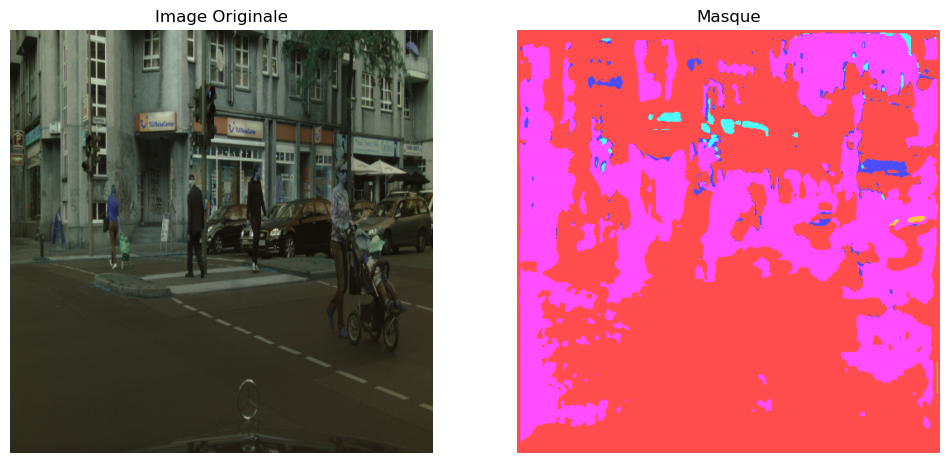

In [436]:
# for i the index of image to check
i = 1
mask_array = prediction[i]

# Charger l'image originale avec OpenCV
original_image_path = os.path.join(test_images_path,os.listdir(test_images_path)[i])
original_image = cv2.imread(original_image_path)

#convert image to mask size
original_image = cv2.resize(original_image, (512, 512))

# Convertir le masque à 8 canaux en masque d'index
mask_channel = (mask_array * 255).astype(np.uint8) #prepare for individual inspection
mask_index = np.argmax(mask_array, axis=-1) 
# Convertir le masque en image OpenCV
mask_image = (mask_index * 255).astype(np.uint8) 

#convert mask to original dimensions
#mask_image = cv2.resize(mask_image, (2048, 1024))

# Créer un masque couleur en utilisant la palette
mask_color = colors[mask_index]

# Afficher les images côte à côte avec Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image originale à droite
axes[0].imshow(original_image)
axes[0].set_title("Image Originale")
axes[0].axis('off')

# Afficher le masque à gauche
#axes[1].imshow(mask_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[1].imshow(mask_color, alpha=0.7) #whole mask
axes[1].set_title("Masque")
axes[1].axis('off')

plt.show()

Seems to predict class 5 everywhere. Class 5 is the "sky" class. Our model is overfit to this class ? 

After further training, model seems to react better

In [438]:
model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 13s/step - iou_score: 0.1347 - loss: 44.8932


[44.967041015625, 0.13275742530822754]

Had excellent results with segmentation_model metrics and losses, but now it's bad

In [440]:
"""
#metrics and losses to load on model
from segmentation_models.losses import bce_jaccard_loss, cce_jaccard_loss
from segmentation_models.metrics import iou_score
"""

'\n#metrics and losses to load on model\nfrom segmentation_models.losses import bce_jaccard_loss, cce_jaccard_loss\nfrom segmentation_models.metrics import iou_score\n'

In [541]:
#saving model
model.save('models_in_progress/first_model.keras')  # The file needs to end with the .keras extension
#load model
#model = keras.models.load_model('models_in_progress/first_model.keras')

In [484]:
my_model = keras.models.load_model('models_in_progress/first_model.keras')

In [472]:
my_model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 15s/step - io_u_1: 0.3507 - loss: 53.6615


[53.785301208496094, 0.35946813225746155]

In [116]:
#custom jaccard loss
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [117]:
EarlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=0
)

In [118]:
# Same model / different LR / different loss function

model2 = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=jaccard_distance , metrics=[iou_score]) #loss should be cce_jaccard_loss

In [119]:
t0 = time.time()

model2.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks = EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 927s 47s/step - iou_score: 0.0623 - loss: 94.0575 - val_iou_score: 0.0377 - val_loss: 96.5047
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 887s 46s/step - iou_score: 0.1082 - loss: 89.7584 - val_iou_score: 0.0661 - val_loss: 94.3445
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 889s 46s/step - iou_score: 0.1647 - loss: 84.6452 - val_iou_score: 0.0903 - val_loss: 91.9286
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 890s 46s/step - iou_score: 0.2267 - loss: 79.1832 - val_iou_score: 0.1121 - val_loss: 89.7510
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 884s 46s/step - iou_score: 0.2918 - loss: 73.3177 - val_iou_score: 0.1444 - val_loss: 86.7567
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 884s 46s/step - iou_score: 0.3592 - loss: 67.0949 - val_iou_score: 0.2104 - val_loss: 80.8222
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 888s 46s/step - iou_score: 0.4053 - loss: 62.7523 - val_iou_score: 0.2818 - val_loss: 74.0220
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 893s 46s/step - iou_score: 0.4

In [120]:
#prediction of trained model
prediction2 = model2.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 108s 11s/step


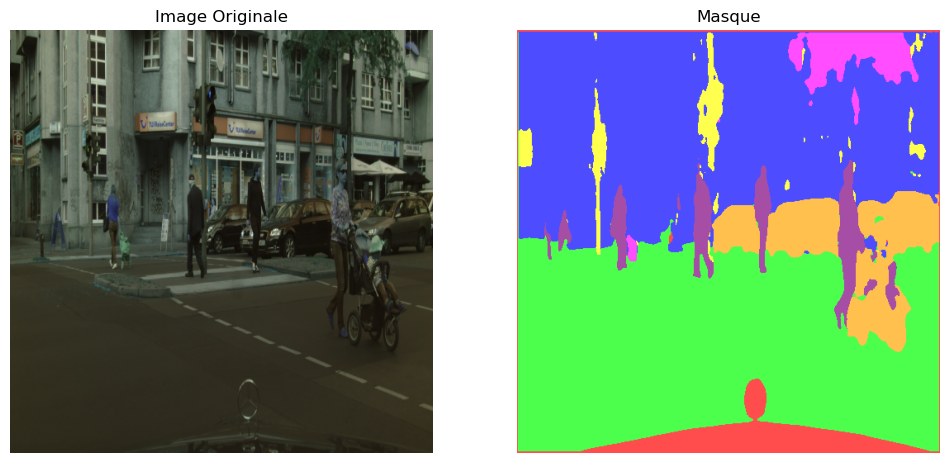

In [121]:
# for i the index of image to check
i = 1
mask_array = prediction2[i]

# Charger l'image originale avec OpenCV
original_image_path = os.path.join(test_images_path,os.listdir(test_images_path)[i])
original_image = cv2.imread(original_image_path)

#convert image to mask size
original_image = cv2.resize(original_image, (512, 512))

# Convertir le masque à 8 canaux en masque d'index
mask_channel = (mask_array * 255).astype(np.uint8) #prepare for individual inspection
mask_index = np.argmax(mask_array, axis=-1) 
# Convertir le masque en image OpenCV
mask_image = (mask_index * 255).astype(np.uint8) 

#convert mask to original dimensions
#mask_image = cv2.resize(mask_image, (2048, 1024))

# Créer un masque couleur en utilisant la palette
mask_color2 = colors[mask_index]

# Afficher les images côte à côte avec Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image originale à droite
axes[0].imshow(original_image)
axes[0].set_title("Image Originale")
axes[0].axis('off')

# Afficher le masque à gauche
#axes[1].imshow(mask_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[1].imshow(mask_color2, alpha=0.7) #whole mask
axes[1].set_title("Masque")
axes[1].axis('off')

plt.show()

In [122]:
model2.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 13s/step - iou_score: 0.7297 - loss: 32.6650


[32.1640510559082, 0.7406392097473145]

Interesting results ... maybe modify the loss function ? try a mix of categoricalcross entropy and Focal_jaccard ?

In [124]:
#using https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models/

In [125]:
#using https://github.com/zhixuhao/unet

In [126]:
# pushing further in https://encord.com/blog/github-repositories-image-segmentation/

In [127]:
# exploreing power jaccard : https://www.scitepress.org/PublishedPapers/2021/103040/103040.pdf

Piste 1 : récupérer les poids d'entrainement de cityscape directement ? trouver un modèle déjà entrainé \
Piste 1.5 : expérimenter avec un autre Backbone ? Xception ? Vggnet mini ? Resnet50 ? \
Piste 2 : data-augment => gagner du temps / gagner en efficacité \
Montrer qu'on est capable mais rappeler que la data-augment prend du temps \
! Justifier l'augment de data => CHOISIR des données où les classes sont présent et augmenter celles ci \
! Simuler des conditions météo \
SINON augmenter le pourcentage de data choisi 

Piste 3 : Dériver l'entrainement vers GPU pour améliorer le traitement de l'image \
! Mettre dans la note technique la différence de traitement par CPU et par GPU !


### STEP 1.5 : Training with other Bakcbones but no preprocess from backbone

In [130]:
#EarlyStop function
EarlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=0
)

In [131]:
#RESNET50
BACKBONE = 'resnet50'
preprocess_input = get_preprocessing(BACKBONE)

#model with CatCross+Jaccard Loss
model_resnet = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model_resnet.compile('Adam', loss=cce_jaccard_loss, metrics=['accuracy', iou_score])

In [ ]:
#model fit
t0 = time.time()

model_resnet.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks = EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 558s 24s/step - accuracy: 0.4248 - iou_score: 0.1445 - loss: 1.0620 - val_accuracy: 0.0689 - val_iou_score: 0.0106 - val_loss: 2.8532
Epoch 2/100


In [ ]:
prediction_resnet = model_resnet.predict(X_test, batch_size=16, verbose=1)

In [ ]:
#Inception
BACKBONE = 'inceptionv3'
preprocess_input = get_preprocessing(BACKBONE)

#EarlyStop function
EarlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    start_from_epoch=0
)

#model with CatCross+Jaccard Loss
model_inception = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model_inception.compile('Adam', loss=cce_jaccard_loss, metrics=['accuracy', iou_score])

In [ ]:
#model fit
t0 = time.time()

model_inception.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks = EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")

In [ ]:
prediction_inception = model_inception.predict(X_test, batch_size=16, verbose=1)

In [ ]:
def prepare_mask_array(mask_array):
    # Convertir le masque à 8 canaux en masque d'index
    mask_channel = (mask_array * 255).astype(np.uint8) #prepare for individual inspection
    mask_index = np.argmax(mask_array, axis=-1) 
    # Convertir le masque en image OpenCV
    #mask_image = (mask_index * 255).astype(np.uint8)
    mask_image = colors[mask_index]
    
    return mask_channel, mask_image

In [ ]:
# for i the index of image to check
i = 1
mask_array_vgg16 = prediction[i]
mask_array_resnet = prediction_resnet[i]
mask_array_inception = prediction_inception[i]

# Charger l'image originale avec OpenCV
original_image_path = os.path.join(test_images_path,os.listdir(test_images_path)[i])
original_image = cv2.imread(original_image_path)

#convert image to mask size
original_image = cv2.resize(original_image, (512, 512))

#prepare each masks and channels
vgg16_channel, vgg16_image = prepare_mask_array(mask_array_vgg16)
resnet_channel, resnet_image = prepare_mask_array(mask_array_resnet)
inception_channel, inception_image = prepare_mask_array(mask_array_inception)

# Créer un masque couleur en utilisant la palette
ind_vgg16 = (vgg16_image/255).astype(np.uint8)
mask_color_vgg16 = colors[ind_vgg16]

# Afficher les images côte à côte avec Matplotlib
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

# Afficher l'image originale à droite
axes[0].imshow(original_image)
axes[0].set_title("Origin image")
axes[0].axis('off')

# Afficher le masque à gauche
#axes[1].imshow(vgg16_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[1].imshow(vgg16_image, alpha=0.7) #whole mask #je triche en utilisant le mak fait plus haut mais pas grave
axes[1].set_title("Mask_vgg16")
axes[1].axis('off')

#axes[2].imshow(resnet_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[2].imshow(resnet_image, cmap='jet', alpha=0.7) #whole mask
axes[2].set_title("Mask_resnet")
axes[2].axis('off')

#axes[3].imshow(inception_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[3].imshow(inception_image, cmap='jet', alpha=0.7) #whole mask
axes[3].set_title("Mask_inception")
axes[3].axis('off')

plt.show()

In [ ]:
i = np.argmax(mask_array_vgg16, axis=-1) 
np.unique(i)
#NO HUMANS ??? OR NO SKY ???

Backbone '''inception''' seems to return better results (need to print out metrics)

To further inquiries, we should now proceed to data-augmentation, see how it can improve results, and how it impacts training and overall process

### Data-Augmentation

In order to data-augment our set, we will use Albumentation library

In [304]:
import albumentations as A

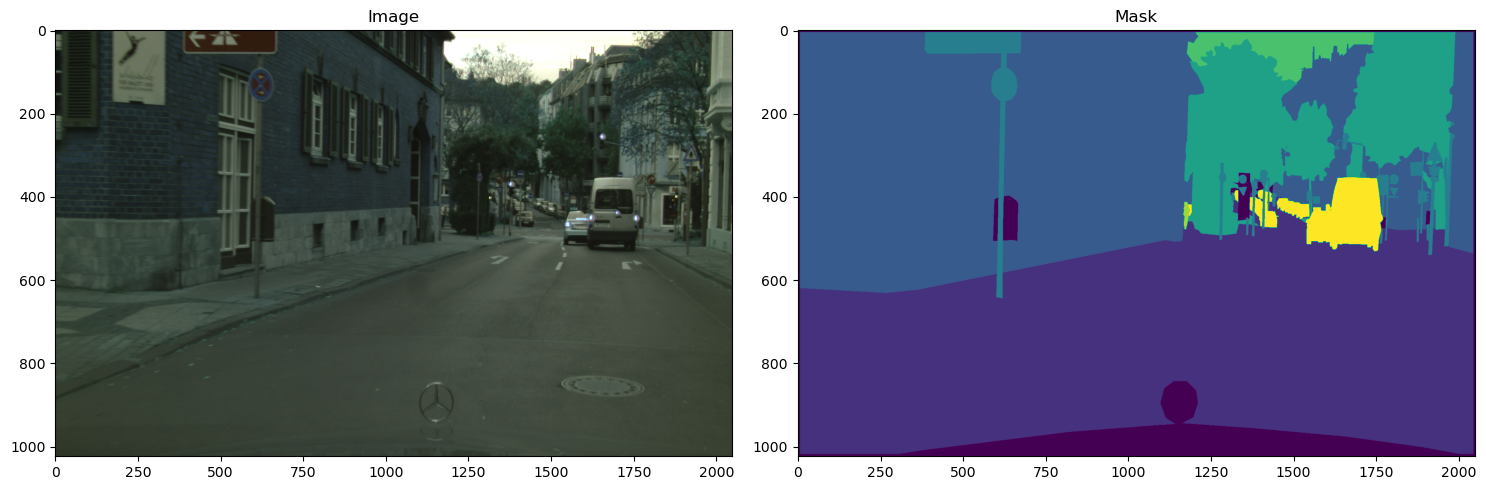

In [319]:
#visualize image and mask before transformation
img_path = os.path.join(train_copied_img_path, os.listdir(train_copied_img_path)[1])
mask_path = os.path.join(train_gen_mask_path, os.listdir(train_gen_mask_path)[1])
img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(15, 5)) #set 2 columns to examine differences between originals and modifications

ax[0].imshow(img, aspect='auto')
ax[0].set_title("Image")

ax[1].imshow(mask, aspect='auto')
ax[1].set_title("Mask")

plt.tight_layout()
plt.show()

In [306]:
"""#select one image and its corresponding mask
train_copied_img_path = "data/train/images"
train_gen_mask_path = "data/train/gen_masks"

img_path = os.path.join(train_copied_img_path, os.listdir(train_copied_img_path)[1])
mask_path = os.path.join(train_gen_mask_path, os.listdir(train_gen_mask_path)[1])

img=cv2.imread(img_path)
mask=cv2.imread(mask_path)
"""
#prepare transformation from documentation
pipeline = A.Compose([
    A.HorizontalFlip(p=0.5), # 50% chance to flip
    A.RandomBrightnessContrast(p=0.8), # 80% chance to adjust brightness/contrast
    A.GaussianBlur(p=0.3), # 30% chance to blur
])

transformed_data = pipeline(image=img, mask=mask)

#transformed_data['image']

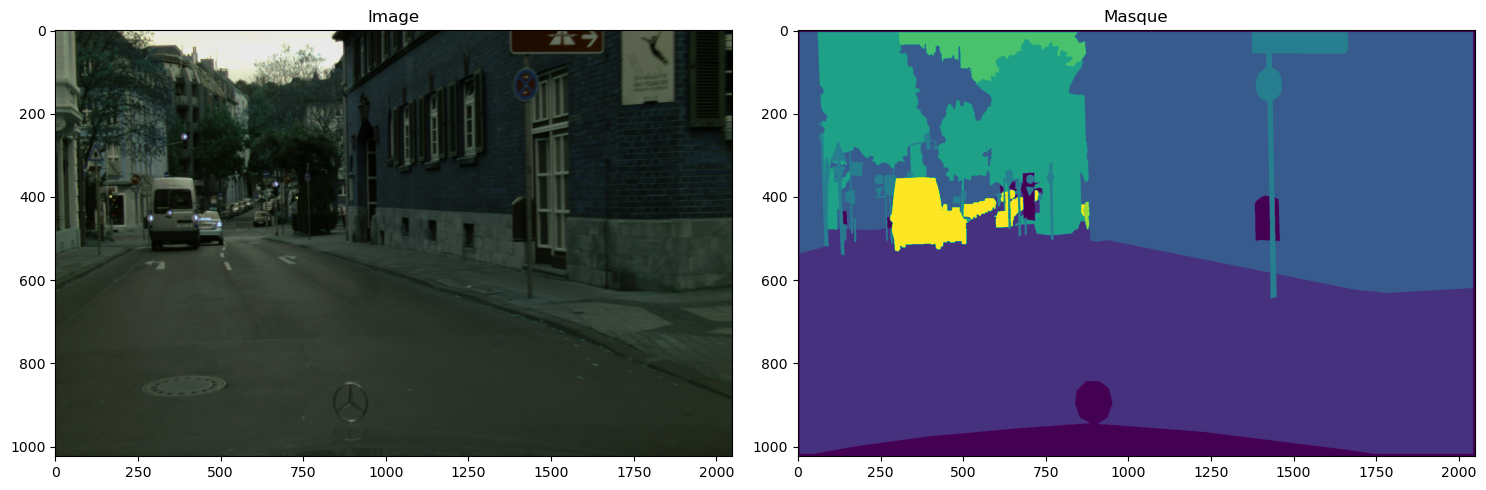

In [307]:
new_img=transformed_data['image']
new_mask=transformed_data['mask']

#visualize images and masks
fig, ax = plt.subplots(1, 2, figsize=(15, 5)) #set 2 columns to examine differences between originals and modifications
ax[0].imshow(new_img, aspect='auto')
ax[0].set_title("Image")

ax[1].imshow(new_mask, aspect='auto')
ax[1].set_title("Masque")

"""ax[0].imshow(img, aspect='auto') 
ax[0].set_title("Image")

ax[1].imshow(mask, aspect='auto')
ax[1].set_title("Masque")"""

plt.tight_layout()
plt.show()

Need to expriment on : 
- A.togray or A.ChannelDropout : in order to avoid model dependance to colors
- A.resize : to have the pipeline resize image itself
- A.affine : for multiple geometric transformation at once